# DS 3000 HW 10

Due: Friday Aug 9th @ 11:59 PM EST

### Submission Instructions
Submit this `ipynb` file to Gradescope (this can also be done via the assignment on Canvas).  To ensure that your submitted files represent your latest code, make sure to give a fresh `Kernel > Restart & Run All` just before uploading the files to gradescope.

### Tips for success
- Start early
- Make use of Piazza
- Make use of Office hour
- Remember to use cells and headings to make the notebook easy to read (if a grader cannot find the answer to a problem, you will receive no points for it)
- Under no circumstances may one student view or share their ungraded homework or quiz with another student [(see also)](http://www.northeastern.edu/osccr/academic-integrity), though you are welcome to **talk about** (not show each other) the problems.

In [1]:
# below are all the modules you will need on this homework
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
import pylab as py
import scipy.stats as stats

## Part 1: Decision Tree (35 total points)

For this problem you will use the `df_owl_2018.csv` file again in your Homework Module on Canvas. This data set contains statistics from the 2018 Overwatch League (cleaned from [this website](https://overwatchleague.com/en-us/statslab?statslab=heroes)). Overwatch is a video game where two teams of 6 players compete against each other. On each team, a player may assume one of three roles:
- Damage: whose job is to attack the other team
- Support: whose job is to heal their own team
- Tank: whose job is to absorb the damage of the other team

However, while those are the general jobs of each role, occasionally a player in one role behaves more like another. In this part, we will see if the numeric statistics from a game of Overwatch can be used to accurately predict the role of a player using a Decision Tree.

In [2]:
df_owl = pd.read_csv('df_owl_2018.csv')
df_owl.head()

,start_time,match_id,stage,map_type,map_name,player,team,hero,role,Ability Damage Done,...,Ultimates Used,Unscoped Accuracy,Unscoped Hits,Unscoped Shots,Venom Mine Kills,Weapon Accuracy,Weapon Kills,Whole Hog Efficiency,Whole Hog Kills,of Rockets Fired
0,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Agilities,Los Angeles Valiant,Genji,Damage,0.0,...,8,0.0,0,0,0,0.273585,0,0.0,0,0.0
1,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Danteh,San Francisco Shock,Genji,Damage,0.0,...,1,0.0,0,0,0,0.166667,0,0.0,0,0.0
2,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Danteh,San Francisco Shock,Junkrat,Damage,0.0,...,3,0.0,0,0,0,0.137500,0,0.0,0,0.0
3,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Danteh,San Francisco Shock,Tracer,Damage,0.0,...,3,0.0,0,0,0,0.327001,0,0.0,0,0.0
4,2018-01-11 00:12:00,10223,Overwatch League - Stage 1,PAYLOAD,Dorado,Envy,Los Angeles Valiant,D.Va,Tank,0.0,...,23,0.0,0,0,0,0.314785,0,0.0,0,0.0


### Part 1.1: Build a Decision Tree (15 points)

Create a Decision Tree to predict the `role` of an Overwatch player using all the numeric statistics as x features:
- Use `max_depth = 3`
- The code for creating the `x_feat_list` is:

```python
x_feat_list = list(df_owl.loc[:,'Ability Damage Done':'of Rockets Fired'].columns)
```
- Plot the tree and make sure you can easily read the nodes of the resulting Decision Tree (you will want to use `plt.gcf().set_size_inches()`)


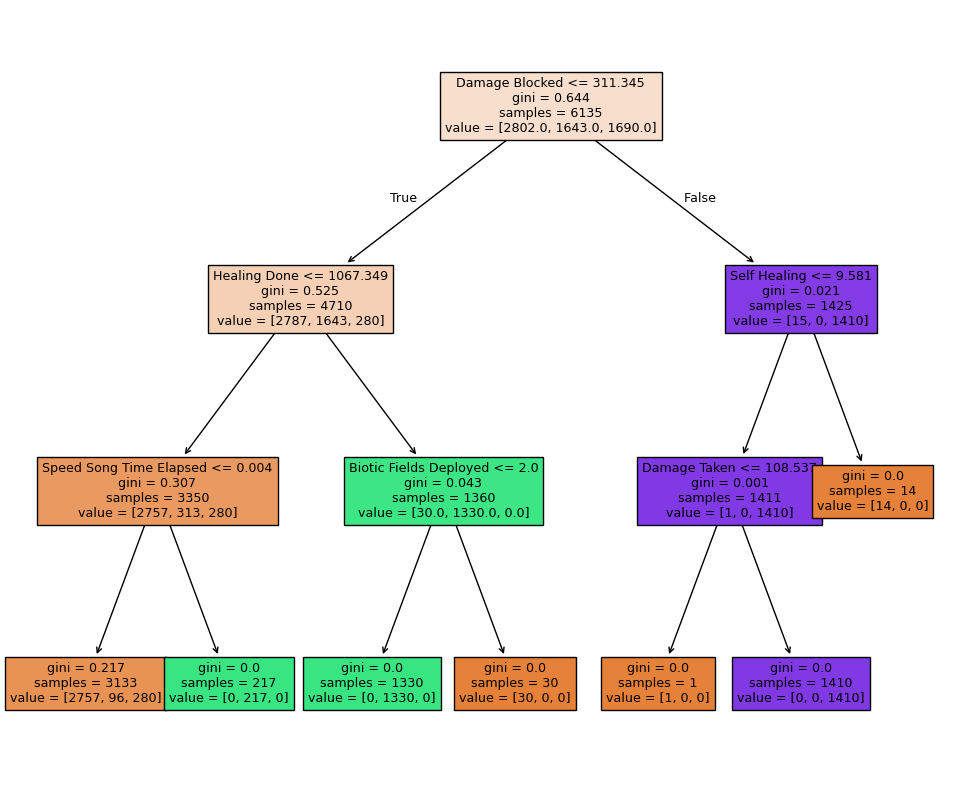

In [3]:
# features and target
x_feat_list = list(df_owl.loc[:, 'Ability Damage Done':'of Rockets Fired'].columns)
X = df_owl[x_feat_list]
y = df_owl['role']

# Decision Tree with max depth of 3
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

# Plot the tree
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=x_feat_list, filled=True)
plt.gcf().set_size_inches(12, 10)
plt.show()

### Part 1.2: Predict Prof. Gerber's Role (5 points)

Thanks to Professor Gerber who created this assignment. 

Professor Gerber used to play a lot of Overwatch, and he would usually play only one role. Download the `df_prof_gerber_ow.csv` file, which contains the average performance of Prof. Gerber when he played his favorite character in the game$^*$.
- Convert it to an array using `np.array`
- Predict the role Prof. Gerber most often played with the `dec_tree_clf.predict` function

$^*$ since Prof. Gerber only had access to some of the statistics, he made guesses for some of the values, but it should be a pretty good estimation.

In [4]:
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=3)
dec_tree_clf.fit(X, y)

# Load the dataset for Prof. Gerber
df_prof_gerber = pd.read_csv('df_prof_gerber_ow.csv')

# Convert df to array 
prof_gerber_array = np.array(df_prof_gerber)

# Predict the role using the given dunction
predicted_role = dec_tree_clf.predict(prof_gerber_array)

# print the results
print('The predicted role for Prof. Gerber is: ', predicted_role[0])

The predicted role for Prof. Gerber is:  Support


C:\Users\nicho\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### Part 1.3: Cross Validate and Compute Accuracy (15 points)

Can we trust this prediction? Peform a 10-fold cross validation Decision Tree, using a Stratified K Fold, and then create a confusion matrix of the resulting predictions vs. the true roles. Calculate the overall accuracy and discuss **in a markdown cell** with 2-3 sentences what you can say about how the decision tree is performing.

Overall Accuracy: 0.94


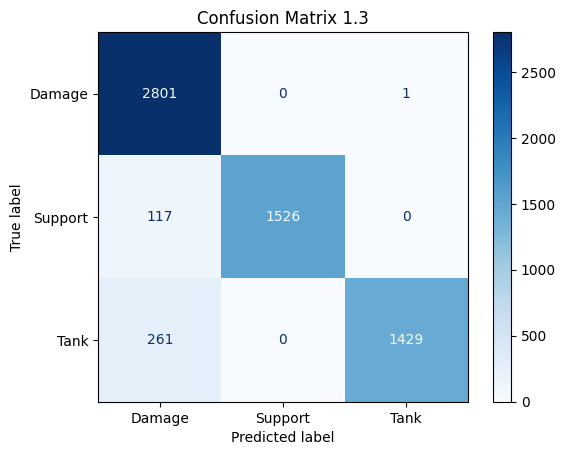

In [5]:
skf = StratifiedKFold(n_splits=10, shuffle=True)
y_pred = cross_val_predict(dec_tree_clf, X, y, cv=skf)

# calulating the accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Overall Accuracy: {accuracy:.2f}')

# make confusion matrix
cm = confusion_matrix(y, y_pred, labels=dec_tree_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dec_tree_clf.classes_)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix 1.3')
plt.show()

$\color{red}{\text{1.3 Markdown explaination}}$

Overall, the decision tree classifier has an accuracy rate of 93%, indicating it usually predicts the roles accurately. The confusion matrix demonstrates that the model performs excellently in recognizing “Damage” players with a mere one error. However, some mistakes are observed between “Support” and “Tank” roles, for instance a few “Support” players were predicted as “Damage”, and also certain ”Tank” players were predicted as “Damage”. Despite theses minor errors, the high level of accuracy suggests that decision tree is capable of predicting player roles using game statistics alone.


## Part 2: Random Forest (50 total points)

We would like to classify the importance of each x-feature in predicting the role of an Overwatch player, as well as avoid complaints that our single decision tree may be overfitting. To accomplish these two tasks, we will build a Random Forest using the same data as from Part 1.

In [6]:
# below are all the modules you will need on this homework
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
import pylab as py
import scipy.stats as stats

### Part 2.1: Build the Random Forest (20 points)

Build a Random Forest Classifier which classifies the `role` of an Overwatch player using all of the numerical statistics from the data. Use `max_depth = 3` and 10-fold cross validation.

**Note:** do *not* specify `n_estimators` more than 1000. 1000 will take a little while to run (and may be worth it), but you may also just use the default of `n_estimators = 100` if you wish (though expect unstable results).

In [7]:
# Repeat initialization and etc. from previous question
df_owl = pd.read_csv('df_owl_2018.csv')
x_feat_list = list(df_owl.loc[:, 'Ability Damage Done':'of Rockets Fired'].columns)
X = df_owl[x_feat_list]
y = df_owl['role']

# start Random Forest Classifier with max depth of 3
rf_clf = RandomForestClassifier(max_depth=3, n_estimators=100)

# Perform 10-fold cross-validation using StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(rf_clf, X, y, cv=skf)

### Part 2.2: Get the Confusion Matrix and Accuracy (10 points)

Create a confusion matrix of the resulting predictions vs. the true roles. Calculate the overall accuracy and discuss **in a markdown cell** with 1-2 sentences what you can say about how the random forest performs compared with the single decision tree. You *should* see at least a slight decrease in performance; why does that make sense? Is it a good/bad thing?

To get the labels for the roles, you'll want to define:

```python
y_feat_list = np.array(['Damage', 'Support', 'Tank'])
```

Overall Accuracy: 0.85


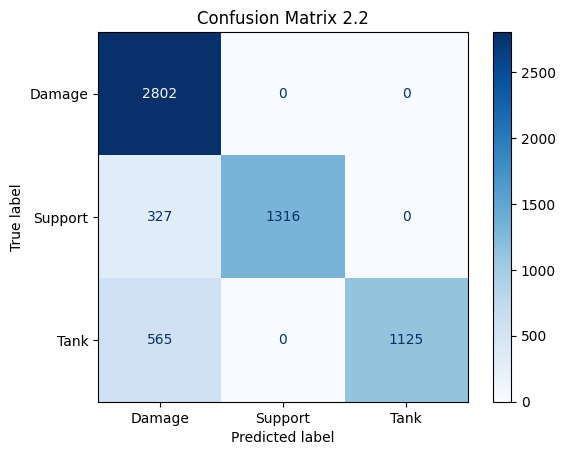

In [8]:
# calc the accuracy
accuracy = accuracy_score(y, y_pred)
print(f'Overall Accuracy: {accuracy:.2f}')

# Gerts labels for the roles to be defined
y_feat_list = np.array(['Damage', 'Support', 'Tank'])

# Creates the confuson matrix
cm = confusion_matrix(y, y_pred, labels=y_feat_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_feat_list)

# display cofusion matriix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix 2.2')
plt.show()

$\color{red}{\text{2.2 Markdown explaination}}$

The overall accuracy of the Random Forrest, 86% was slighty lower than the single decision tree's accuraxy of 93%. This makes some sense, as random forests use multiple trees to prevent overfitting of their models, which could reduce accuracy in the case of training data. However, this could actually be a good thing since it's more likely to have a better model on new unseen data, making it reliable overall.


### Part 2.3: Feature Importance (10 points)

Print a bar plot (You can use the function in the lecture note) to describe the top 10 features which are most useful for classification.  Qualitatively describe if these most important features are meaningful. In other words:
- If the classifier performs well, we care about which features helped it work
- If the classifier doesn't perform well, we don't care which features helped it "work"

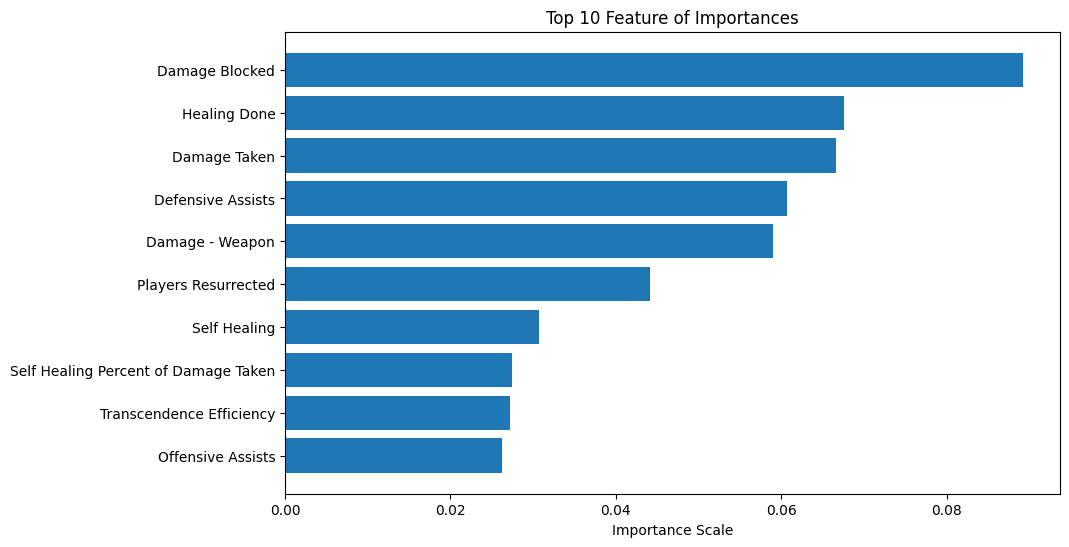

In [9]:
# re initialize all the parts from previous parts of the question
df_owl = pd.read_csv('df_owl_2018.csv')
x_feat_list = list(df_owl.loc[:, 'Ability Damage Done':'of Rockets Fired'].columns)
X = df_owl[x_feat_list]
y = df_owl['role']
rf_clf = RandomForestClassifier(max_depth=3, n_estimators=100)
rf_clf.fit(X, y)

# Top 10 features
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[-10:]  

# Plot the feature importances of the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [x_feat_list[i] for i in indices])
plt.xlabel('Importance Scale')
plt.title('Top 10 Feature of Importances')
plt.show()

### Part 2.4: Feature Importance (10 points)

Based on the result in Part 2.3, Fit another tree model with the top 5 features in the random forest, and print the tree plot. 

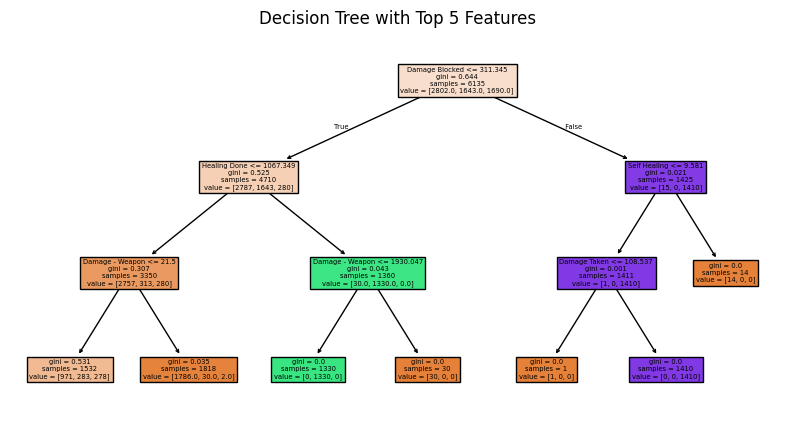

In [10]:
top_5 = [x_feat_list[i] for i in indices]
X_top_5 = df_owl[top_5]

# Decision tree with the top 5 features
dt_clf = DecisionTreeClassifier(max_depth=3)
dt_clf.fit(X_top_5, y)

# plotting the treu
plt.figure(figsize=(10, 5))
tree.plot_tree(dt_clf, feature_names=top_5, filled=True)
plt.title('Decision Tree with Top 5 Features')
plt.show()

## Part 3: Summary on models (15 points)

In your own words, explain the difference between multiple linear regression, decision tree and random forest. For each model, please list:
- How the model works
- When the model is applicable
- Any assumption required for the model
- Pros and cons for the model


## $\color{red}{\text{Multiple Linear Regression}}$

### How it works
Multiple linear regression is a technique to find relationships between variables by fitting a linear equation for the data. 

### When the model is applicable
It is applicable in order to understand the relationship between the dependent variable and multiple independent variables. 

### Any assumption required for the model
It assumes that the relationship between the variables are linear, hence the name Multiple LINEAR Regression.

### Pros and cons for the model
Its pros are that it is a simple technic and is effiecent. The cons are that the realtonship between two varaible may not alway be linear 


## $\color{red}{\text{Decision Tree}}$

### How it works
A decision tree is a model that seperates the data into susets based on the input. The nodes represent the decision and each branch represents the outcome and teh leaves are the prediction

### When the model is applicable
This model is applicable for non linear relationships between varaibles and when you need a model that is easy to look at and understand

### Any assumption required for the model
The only assumption is that it can be split into subsets

### Pros and cons for the model
Pros are that it is easily understood and can handle non linear relationships and the cons are that it can create biased trees in which some classes overpower


## $\color{red}{\text{Random Forest}}$

### How it works
Random Forrest works by constructing multiple decision trees and produces the avaerage of the trees which in turn reduces the variance factor

### When the model is applicable
This is applicable when you want a more accurate decsiion tree and when you have a lot of features in your data

### Any assumption required for the model
Not really many assumptions other than those in the decsion trees that there could be a split as well as that there are actual values in the variables. In addition, if there are a large number of trees the algortihm may take a long time 

### Pros and cons for the model
Pros are that it reduces variance by averaging multiple trees and can handle large data sets well. Cons are that it takes more computationally to operate because you are creating multiple decision trees and requires more parameters to operate